# Part 3 : Mitigate Bias, Train another unbiased Model and Put in the Model Registry

<a id='aup-overview'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 0 : Overview, Architecture and Data Exploration](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
* **[Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)**
  * **[Architecture](#train2)**
  * **[Develop a second model](#second-model)**
  * **[Analyze the Second Model for Bias](#analyze-second-model)**
  * **[View Results of Clarify Bias Detection Job](#view-second-clarify-job)**
  * **[Configure and Run Clarify Explainability Job](#explainability)**
  * **[Create Model Package for the Second Trained Model](#model-package)**
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
* [Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)

이 노트북에서는 Clarify를 사용하여 편향을 감지하고, SMOTE를 사용하여 이를 완화하고, 다른 모델을 훈련하고, 그 과정에서 생성된 모든 아티팩트 계보(데이터, 코드 및 모델 메타데이터)와 함께 모델 레지스트리에 배치하는 방법을 설명합니다.

### Install required and/or update third-party libraries

In [1]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.1 boto3==1.16.48

In [2]:
!python -m pip install -q shap
#만약 위 명령어 실행이 실패할 경우 노트북 안에 터미털 이모티콘을 클릭한 뒤 터미널에서 아래 명령어를 실행 합니다. 
#conda install -c conda-forge shap -y

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.7/site-packages/slicer-0.0.7.dist-info/RECORD'



In [43]:
import sys
import IPython
install_needed = True  # should only be True once
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
     |████████████████████████████████| 406 kB 23.5 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.34.0-py2.py3-none-any.whl size=571572 sha256=b0341f9c697ca55a7a685a404346997fd8d61dc2b5d1ba59c5c2d91e154bc395
  Stored in directory: /root/.cache/pip/wheels/4f/2e/03/099f1da48f5142c54888db1b61e8e83d4d74b14c70a0e2a173
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.23.1
    Uninstalling sagemaker-2.23.1:
      Successfully uninstalled sagemaker-2.23.1
     |████████████████████████████████| 263 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 1.5 MB/s  eta 0:00:01


### Import libraries

In [20]:
import json
import time
import boto3
import shap
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.xgboost.estimator import XGBoost

from model_package_src.inference_specification import InferenceSpecification


%matplotlib inline

### Load stored variables

이전에 이 노트북을 실행한 경우, AWS에서 생성한 리소스를 재사용할 수 있습니다. 아래 셀을 실행하여 이전에 생성된 변수를 로드합니다. 기존 변수의 출력물이 표시되어야 합니다. 인쇄된 내용이 보이지 않으면 노트북을 처음 실행한 것일 수 있습니다.

In [21]:
%store -r
%store

Stored variables and their in-db values:
bucket                              -> 'sagemaker-us-east-1-870180618679'
claims_fg_name                      -> 'fraud-detect-demo-claims'
claims_table                        -> 'fraud-detect-demo-claims-1618149822'
clarify_bias_job_1_name             -> 'Clarify-Bias-2021-04-12-14-04-59-864'
clarify_bias_job_2_name             -> 'Clarify-Bias-2021-04-11-15-19-23-754'
clarify_expl_job_name               -> 'Clarify-Explainability-2021-04-12-13-11-43-108'
col_order                           -> ['fraud', 'total_claim_amount', 'police_report_ava
customers_fg_name                   -> 'fraud-detect-demo-customers'
customers_table                     -> 'fraud-detect-demo-customers-1618149825'
database_name                       -> 'sagemaker_featurestore'
endpoint_name                       -> 'fraud-detect-demo-xgboost-post-smote-endpoint'
hyperparameters                     -> {'max_depth': '3', 'eta': '0.2', 'objective': 'bin
model_1_name      

**<font color='red'>Important</font>: StoreMagic 명령을 사용하여 변수를 검색하려면 이전 노트북을 실행해야 합니다.**

### Set region, boto3 and SageMaker SDK variables

In [22]:
#You can change this to a region of your choice
import sagemaker
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [23]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client('sts').get_caller_identity()["Account"]

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210405T171777 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


In [24]:
# variables used for parameterizing the notebook run
model_2_name = f'{prefix}-xgboost-post-smote'
%store model_2_name

train_data_upsampled_s3_path = f's3://{bucket}/{prefix}/data/train/upsampled/train.csv'
bias_report_2_output_path = f's3://{bucket}/{prefix}/clarify-output/bias_2'
explainability_output_path = f's3://{bucket}/{prefix}/clarify-output/explainability'

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = 'ml.c5.xlarge'

Stored 'model_2_name' (str)


<a id ='train2'> </a>
## Architecture for this ML Lifecycle Stage : Train, Check Bias, Tune, Record Lineage, Register Model
[overview](#aup-overview)
___

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

<a id='second-model'></a>

## Develop a second model

[overview](#aup-overview)
___

이 두 번째 모델에서는 SMOTE를 사용하여 데이터셋의 성별 불균형을 수정하고 XGBoost를 사용하여 다른 모델을 훈련합니다. 이 모델은 또한 레지스트리에 저장되고 최종적으로 배포가 승인됩니다.

In [25]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

<a id='smote'></a>
### Resolve class imbalance using SMOTE

불균형을 처리하기 위해 [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf)를 사용하여 소수 클래스를 오버샘플링 (즉, 업샘플링) 할 수 있습니다. imbalanced-learn 모듈을 설치한 후 SMOTE를 임포트할 때 ImportError가 발생하면 커널을 다시 시작하십시오.

#### Gender balance before SMOTE

In [26]:
gender = train['customer_gender_female']
gender.value_counts()

0    2226
1    1774
Name: customer_gender_female, dtype: int64

#### Gender balance after SMOTE

In [27]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled['customer_gender_female'].value_counts()

1    2226
0    2226
Name: customer_gender_female, dtype: int64

### Train new model & Monitor with Debugger


In [43]:
train_data_upsampled.to_csv('data/upsampled_train.csv', index=False)
s3_client.upload_file(Filename='data/upsampled_train.csv', Bucket=bucket, Key=f'{prefix}/data/train/upsampled/train.csv')

In [44]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

rules=[ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)

)

In [45]:
xgb_estimator = XGBoost(
    entry_point = "xgboost_starter_script.py",
    hyperparameters = hyperparameters,
    role = sagemaker_role,
    instance_count = train_instance_count,
    instance_type = train_instance_type,
    profiler_config=profiler_config,
    framework_version = "1.0-1",
    rules=rules
    )

In [46]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

if 'training_job_2_name' not in locals():
    
    xgb_estimator.fit(inputs = {'train': train_data_upsampled_s3_path},wait=False)
    training_job_2_name = xgb_estimator.latest_training_job.job_name
    %store training_job_2_name
    
    
    tj = TrainingJob(training_job_2_name, region)
    tj.wait_for_sys_profiling_data_to_be_available()
    rule_output_path = xgb_estimator.output_path + xgb_estimator.latest_training_job.job_name + "/rule-output"
    %store rule_output_path
else:
    
    print(f'Using previous training job: {training_job_2_name}')

Using previous training job: sagemaker-xgboost-2021-04-11-15-05-06-441


In [49]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts  = TimelineCharts(system_metrics_reader, 
                                       framework_metrics_reader=None,
                                       select_dimensions=["CPU","I/O"],
                                       select_events=["total"])

print(f"You will find the profiler report in {rule_output_path}")

[2021-04-12 18:18:26.601 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:10557 INFO metrics_reader_base.py:134] Getting 3 event files
select events:['total']
select dimensions:['CPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1'}


You will find the profiler report in s3://sagemaker-us-east-1-870180618679/sagemaker-xgboost-2021-04-12-18-07-15-851/rule-output


### Register artifacts

In [51]:
training_job_2_info = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_2_name)

#### Code artifact

In [52]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info['HyperParameters']['sagemaker_submit_directory']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=code_s3_uri,
    sagemaker_session=sagemaker_session))

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f'Using existing artifact: {code_artifact.artifact_arn}')
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainingScript',
        source_uri=code_s3_uri,
        artifact_type='Code',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {code_artifact.artifact_arn}: SUCCESSFUL')

Create artifact arn:aws:sagemaker:us-east-1:870180618679:artifact/976fddc121e8d38613078d914786b4f6: SUCCESSFUL


#### Training data artifact

In [53]:
training_data_s3_uri = training_job_2_info['InputDataConfig'][0]['DataSource']['S3DataSource']['S3Uri']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=training_data_s3_uri,
    sagemaker_session=sagemaker_session))

if list_response:
    training_data_artifact = list_response[0]
    print(f'Using existing artifact: {training_data_artifact.artifact_arn}')
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainingData',
        source_uri=training_data_s3_uri,
        artifact_type='Dataset',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-1:870180618679:artifact/2c1fef7742febd0419eda73f10ae44ec


#### Model artifact

In [54]:
trained_model_s3_uri = training_job_2_info['ModelArtifacts']['S3ModelArtifacts']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=trained_model_s3_uri,
    sagemaker_session=sagemaker_session))

if list_response:
    model_artifact = list_response[0]
    print(f'Using existing artifact: {model_artifact.artifact_arn}')
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainedModel',
        source_uri=trained_model_s3_uri,
        artifact_type='Model',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {model_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-1:870180618679:artifact/a7035e3c761ef8ae958e969e9ecddff0


### Set artifact associations

In [55]:
trial_component = sagemaker_boto_client.describe_trial_component(TrialComponentName=training_job_2_name+'-aws-training-job')
trial_component_arn = trial_component['TrialComponentArn']

#### Input artifacts

In [56]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type='ContributedTo',
            sagemaker_session=sagemaker_session)
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:870180618679:experiment-trial-component/sagemaker-xgboost-2021-04-12-18-07-15-851-aws-training-job and arn:aws:sagemaker:us-east-1:870180618679:artifact/976fddc121e8d38613078d914786b4f6: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-1:870180618679:experiment-trial-component/sagemaker-xgboost-2021-04-12-18-07-15-851-aws-training-job and arn:aws:sagemaker:us-east-1:870180618679:artifact/2c1fef7742febd0419eda73f10ae44ec.



#### Output artifacts

In [57]:
output_artifacts = [model_artifact]

for artifact_arn in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type='Produced',
            sagemaker_session=sagemaker_session)
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Association already exists between arn:aws:sagemaker:us-east-1:870180618679:experiment-trial-component/sagemaker-xgboost-2021-04-12-18-07-15-851-aws-training-job and arn:aws:sagemaker:us-east-1:870180618679:artifact/2c1fef7742febd0419eda73f10ae44ec.



<pre>

</pre>

<a id ='analyze-second-model'></a>
## Analyze the second model for bias and explainability

[overview](#aup-overview)
___
Amazon SageMaker Clarify는 머신 러닝 (ML) 모델이 예측을 수행하는 방법을 설명하는 데 도움이 되는 도구를 제공합니다. 이러한 도구는 ML 모델러와 개발자 및 기타 내부 이해 관계자가 배포 전에 모델 특성을 전체적으로 이해하고 배포 후 모델에서 제공하는 예측을 디버그하는 데 도움이 될 수 있습니다. ML 모델이 예측에 어떻게 도달하는지에 대한 투명성은 모델 예측을 기반으로 결정을 받아들일 경우, 이를 신뢰해야 하는 소비자 및 규제 기관에게도 중요합니다. SageMaker Clarify는 모델에 구애받지 않는(model-agnostic) 피쳐 속성 접근 방식을 사용합니다. 모델 훈련 후 예측을 수행 한 이유를 이해하고 추론 중에 인스턴스 별 설명을 제공하는 데 사용할 수 있습니다. 구현에는 각 피쳐에 특정 예측에 대한 중요도 값을 할당하는 협동 게임 이론 분야의 Shapley 값 개념을 기반으로 확장 가능하고(scalable) 효율적인 SHAP 구현([see paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)이 포함됩니다. 

### Create model from estimator

In [58]:
model_matches = sagemaker_boto_client.list_models(NameContains=model_2_name)['Models']

if not model_matches:
    
    model_2 = sagemaker_session.create_model_from_job(
        name=model_2_name,
        training_job_name=training_job_2_info['TrainingJobName'],
        role=sagemaker_role,
        image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
    %store model_2_name
    
else:
    
    print(f"Model {model_2_name} already exists.")

Model fraud-detect-demo-xgboost-post-smote already exists.


<a id='bias-v1'></a>
### Check for data set bias and model bias

SageMaker를 사용하면 사전 훈련 및 사후 훈련 편향을 확인할 수 있습니다. 사전 훈련 metric은 해당 데이터의 기존 metric을 보여주는 반면, 사후 훈련 metric은 모델의 예측에서 편향을 보여줍니다. SageMaker SDK를 사용하여 편향을 확인하려는 그룹과 표시할 metric을 지정할 수 있습니다.

전체 Clarify 작업을 실행하려면, 아래 셀에서 코드의 주석 처리를 제거해야 합니다. 작업을 실행하는 데 약 15분 정도 소요됩니다. 시간을 절약하려면 편향 작업이 실행되지 않은 경우 미리 생성된 결과를 로드한 후, 다음 셀에서 결과를 볼 수 있습니다.

In [59]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    sagemaker_session=sagemaker_session)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label='fraud',
    headers=train.columns.to_list(),
    dataset_type='text/csv')

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type='text/csv')

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name='customer_gender_female',
    facet_values_or_threshold=[1])

# # un-comment the code below to run the whole job

if 'clarify_bias_job_2_name' not in locals():

    clarify_processor.run_bias(
         data_config=bias_data_config,
         bias_config=bias_config,
         model_config=model_config,
         model_predicted_label_config=predictions_config,
         pre_training_methods='all',
         post_training_methods='all')

    clarify_bias_job_2_name = clarify_processor.latest_job.name
    %store clarify_bias_job_2_name

else:
    print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')


Clarify job Clarify-Bias-2021-04-11-15-19-23-754 has already run successfully.


<a id ='view-second-clarify-job'></a>
## View results of Clarify job
[overview](#aup-overview)
___

데이터셋 또는 모델에서 Clarify를 실행하는 데 15분 정도 걸릴 수 있습니다. 작업을 실행할 시간이 없는 경우, 이 데모에 포함된 미리 생성된 결과를 볼 수 있습니다. 그렇지 않으면 위의 셀에서 코드 주석 처리를 제거하여 작업을 실행할 수 있습니다.

In [60]:
if 'clarify_bias_job_2_name' in locals():
    s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/bias_2/analysis.json', 
        Filename = 'clarify_output/bias_2/analysis.json'
    )
    print(f'Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n')
else:
    print(f'Loading pre-generated analysis file...\n')

with open('clarify_output/bias_1/analysis.json', 'r') as f:
        bias_analysis = json.load(f)

results = bias_analysis['pre_training_bias_metrics']['facets']['customer_gender_female'][0]['metrics'][1]
print(json.dumps(results, indent=4))

with open('clarify_output/bias_2/analysis.json', 'r') as f:
        bias_analysis = json.load(f)

results = bias_analysis['pre_training_bias_metrics']['facets']['customer_gender_female'][0]['metrics'][1]
print(json.dumps(results, indent=4))

Downloaded analysis from previous Clarify job: Clarify-Bias-2021-04-11-15-19-23-754

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.398
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


<a id ='explainability' ></a>
## Configure and run explainability job
[overview](#aup-overview)
___
전체 Clarify 작업을 실행하려면, 아래 셀에서 코드의 주석 처리를 제거해야 합니다. 작업을 실행하는 데 약 15분 정도 소요됩니다. 시간을 절약하려면 편향 작업이 실행되지 않은 경우 미리 생성된 결과를 로드한 후, 다음 셀에서 결과를 볼 수 있습니다.

In [61]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type='text/csv')

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()],
    num_samples=100,
    agg_method='mean_abs',
    save_local_shap_values=True)  ## Save local shap values for later analysis

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label='fraud',
    headers=train.columns.to_list(),
    dataset_type='text/csv')

# un-comment the code below to run the whole job

if 'clarify_expl_job_name' not in locals():

     clarify_processor.run_explainability(
         data_config=explainability_data_config,
        model_config=model_config,
         explainability_config=shap_config)
    
     clarify_expl_job_name = clarify_processor.latest_job.name
     %store clarify_expl_job_name
    
else:
     print(f'Clarify job {clarify_expl_job_name} has already run successfully.')


Clarify job Clarify-Explainability-2021-04-12-13-11-43-108 has already run successfully.


### View Clarify explainability results (shortcut)
데이터셋 또는 모델에서 Clarify를 실행하는 데 15분 정도 걸릴 수 있습니다. 작업을 실행할 시간이 없는 경우, 이 데모에 포함된 미리 생성된 결과를 볼 수 있습니다. 그렇지 않으면 위의 셀에서 코드 주석 처리를 제거하여 작업을 실행할 수 있습니다.

Downloaded analysis from previous Clarify job: Clarify-Explainability-2021-04-12-13-11-43-108



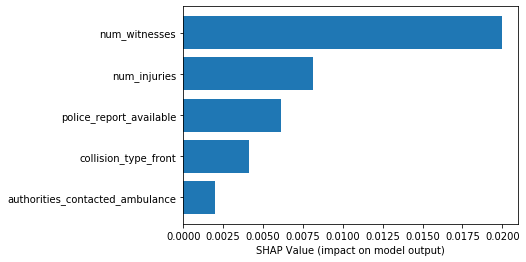

In [62]:
if 'clarify_expl_job_name' in locals():
    s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/explainability/analysis.json', 
        Filename = 'clarify_output/explainability/analysis.json'
    )
    print(f'Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n')
else:
    print(f'Loading pre-generated analysis file...\n')

with open('clarify_output/explainability/analysis.json', 'r') as f:
        analysis_result = json.load(f)
        
shap_values = pd.DataFrame(analysis_result['explanations']['kernel_shap']["label0"])
importances = shap_values['global_shap_values'].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()  
ax.set_xlabel('SHAP Value (impact on model output)');

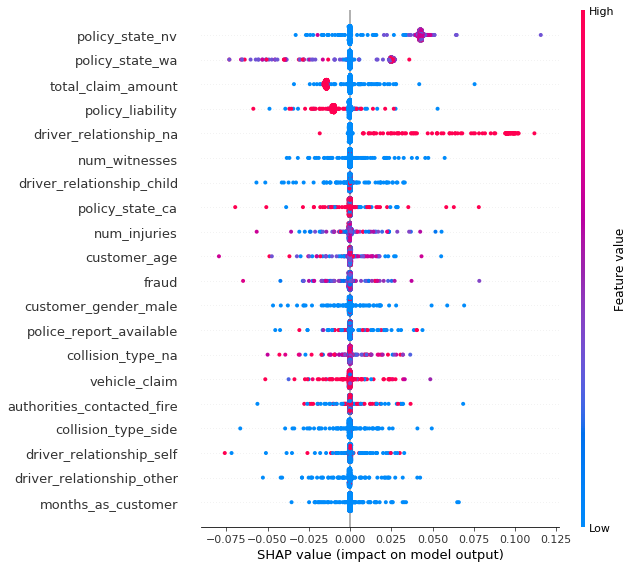

In [63]:
shap.initjs()
s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/explainability/explanations_shap/out.csv', 
        Filename = 'out.csv'
    )

local_shap_values=pd.read_csv('out.csv')
train_data=train_data_upsampled.drop(columns='fraud')
shap.summary_plot(shap_values=local_shap_values.to_numpy(),features=train_data.to_numpy(),feature_names=train.columns.to_list())

자동 생성된 SageMaker Clarify 보고서를 보려면, 다음 코드를 실행하고 출력 링크를 사용하여 보고서를 엽니다.

In [64]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf"))

'Click link below to view the SageMaker Clarify report'

/root/sagemaker-studio-end-to-end/clarify_output/report.pdf

### What is SHAP?

SHAP은 이 솔루션에서 설명을 계산하는 데 사용되는 방법입니다. 단일 feature
permutation과 같은 다른 feature attribution 방법과 달리 SHAP는 가능한 모든 피쳐 조합을 조사하여 단일 피쳐의 효과를 분리하려고 합니다.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017)는 SHapley Additive exPlanations를 나타냅니다. 'Shapley'는 설명을 만드는 데 사용되는 [Shapley
values](https://en.wikipedia.org/wiki/Shapley_value)라는 게임 이론 개념과 관련이 있습니다. Shapley 값은 가능한 모든 '연합'을 고려할 때 각 '플레이어'의 한계 기여도를 나타냅니다. 머신 러닝 컨텍스트에서 이를 사용하여 Shapley 값은 가능한 모든 피쳐 셋을 고려할 때 각 피쳐의 한계 기여도를 설명합니다. 'Additive'는 이러한 Shapley 값을 합하여 최종 모델 예측을 제공할 수 있다는 사실과 관련이 있습니다.

예를 들어 기본 신용 불이행(credit default risk) 위험도 10%로 시작할 수 있습니다. 피쳐 집합이 주어지면, 각 피쳐에 대한 Shapley 값을 계산할 수 있습니다. 모든 Shapley 값을 합하면 +30%의 누적 값을 얻을 수 있습니다. 따라서 동일한 피쳐 세트가 주어지면 모델이 신용 불이행 위험 도 40% (즉, 10% + 30%)를 반환할 것으로 예상합니다.

<a id='model-package' ></a>
## Create Model Package for the Second Trained Model
[overview](#aup-overview)
___

#### Create and upload second model metrics report

In [28]:
model_metrics_report = {'classification_metrics': {}}
for metric in training_job_2_info['FinalMetricDataList']:
    stat = {metric['MetricName']: {'value': metric['Value']}}
    model_metrics_report['classification_metrics'].update(stat)
    
with open('training_metrics.json', 'w') as f:
    json.dump(model_metrics_report, f)
    
metrics_s3_key = f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
s3_client.upload_file(Filename='training_metrics.json', Bucket=bucket, Key=metrics_s3_key)

In [29]:
model_metrics_report

{'classification_metrics': {'validation:auc': {'value': 0.8119202256202698},
  'train:auc': {'value': 0.9515061974525452}}}

#### Define inference specification

In [30]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info['AlgorithmSpecification']['TrainingImage'],
    supports_gpu=False,
    supported_content_types=['text/csv'],
    supported_mime_types=['text/csv'])

mp_inference_spec['InferenceSpecification']['Containers'][0]['ModelDataUrl'] = training_job_2_info['ModelArtifacts']['S3ModelArtifacts']

#### Define model metrics

In [31]:
model_metrics = {
    'ModelQuality': {
        'Statistics': {
            'ContentType': 'application/json',
            'S3Uri': f's3://{bucket}/{prefix}/{metrics_s3_key}'
        }
    },
    'Bias': {
        'Report': {
            'ContentType': 'application/json',
            'S3Uri': f'{explainability_output_path}/analysis.json'
        }
    }
}

#### Register second model package to Model Package Group

In [32]:
mp_input_dict = {
    'ModelPackageGroupName': mpg_name,
    'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
    'ModelApprovalStatus': 'PendingManualApproval',
    'ModelMetrics': model_metrics
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_boto_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response['ModelPackageArn']
%store mp2_arn

Stored 'mp2_arn' (str)


#### Check status of model package creation

In [33]:
mp_info = sagemaker_boto_client.describe_model_package(ModelPackageName=mp2_response['ModelPackageArn'])
mp_status = mp_info['ModelPackageStatus']

while mp_status not in ['Completed', 'Failed']:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(ModelPackageName=mp2_response['ModelPackageArn'])
    mp_status = mp_info['ModelPackageStatus']
    print(f'model package status: {mp_status}')
print(f'model package status: {mp_status}')

model package status: Completed


### View both models in the registry

In [34]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)['ModelPackageSummaryList']

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 9,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:870180618679:model-package/fraud-detect-demo/9',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 4, 12, 15, 40, 23, 923000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 8,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:870180618679:model-package/fraud-detect-demo/8',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 4, 12, 15, 39, 41, 243000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 7,
  'ModelPackageArn': 'arn:aws:sagemaker:us-e

___

### Next Notebook: [Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)